                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0.000000      23.1000

c:\Users\hp\Desktop\AI projects\solar-challenge-week0-1\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


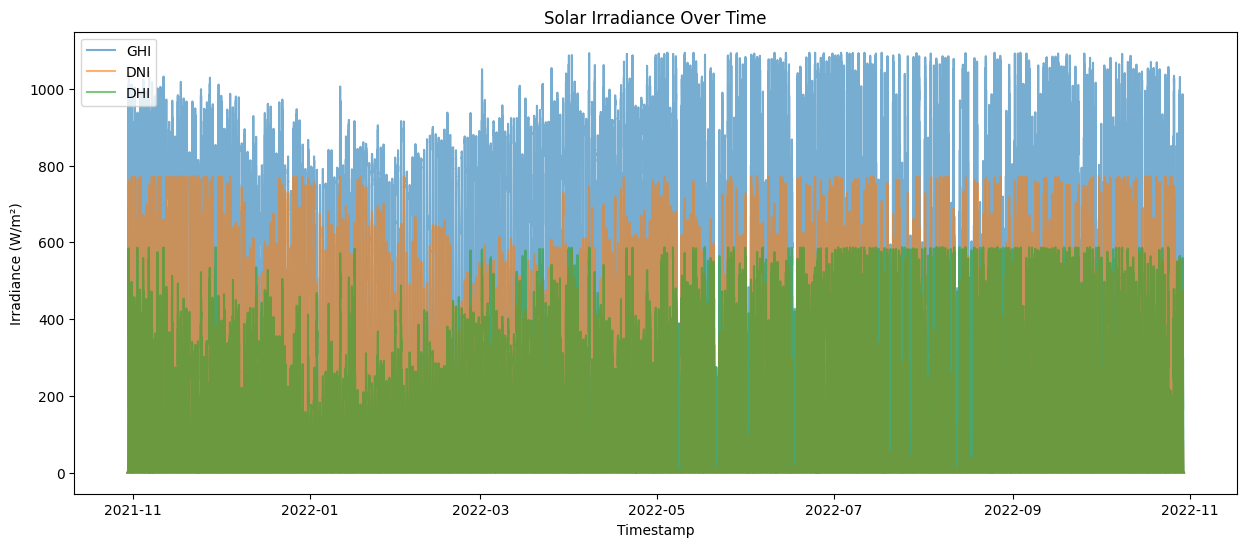

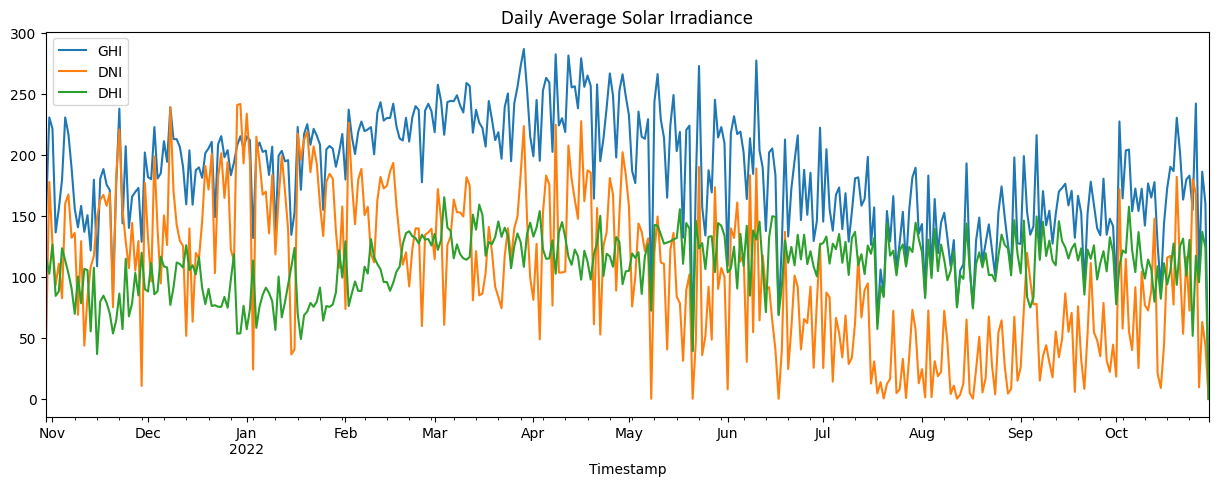

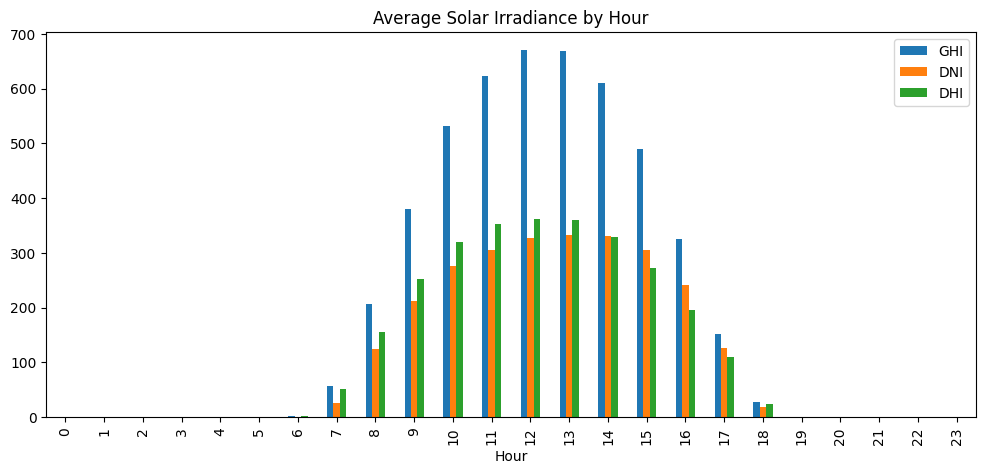

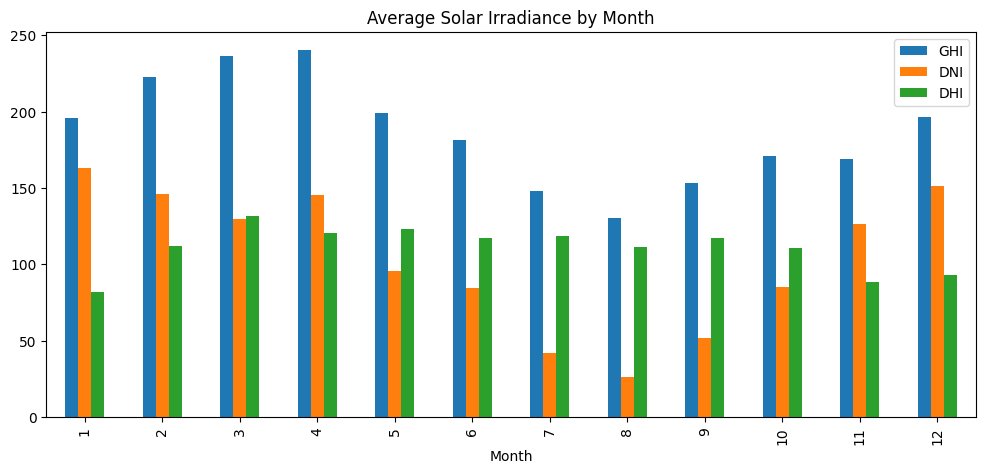

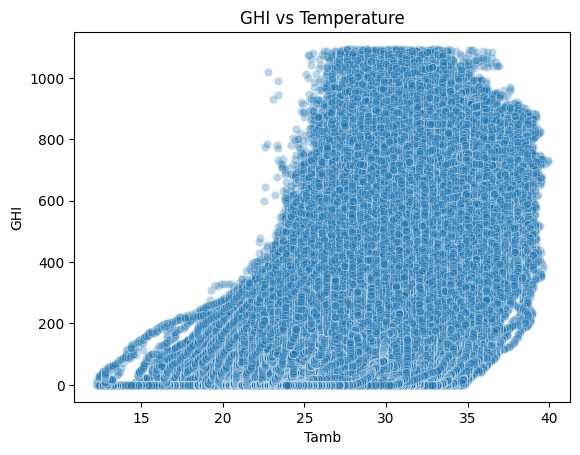

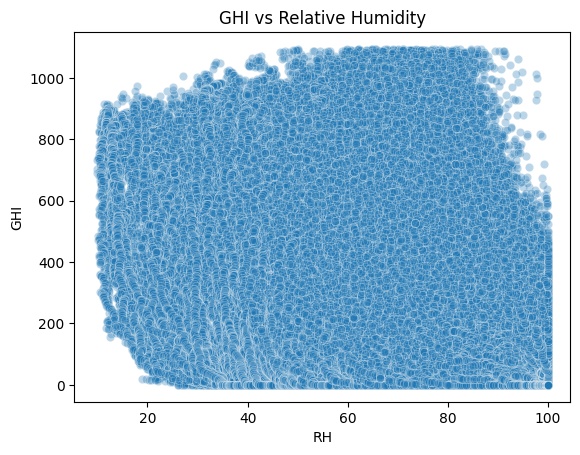

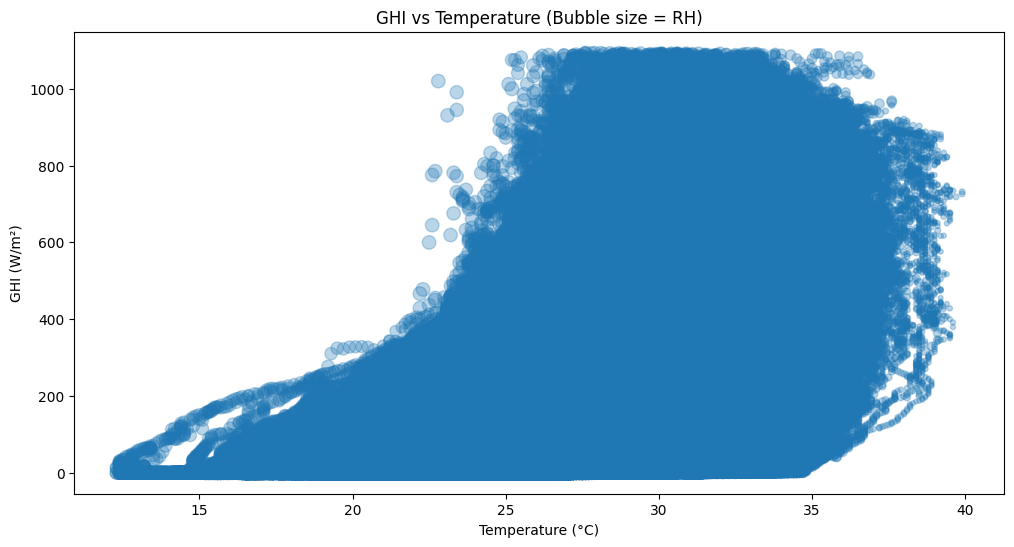

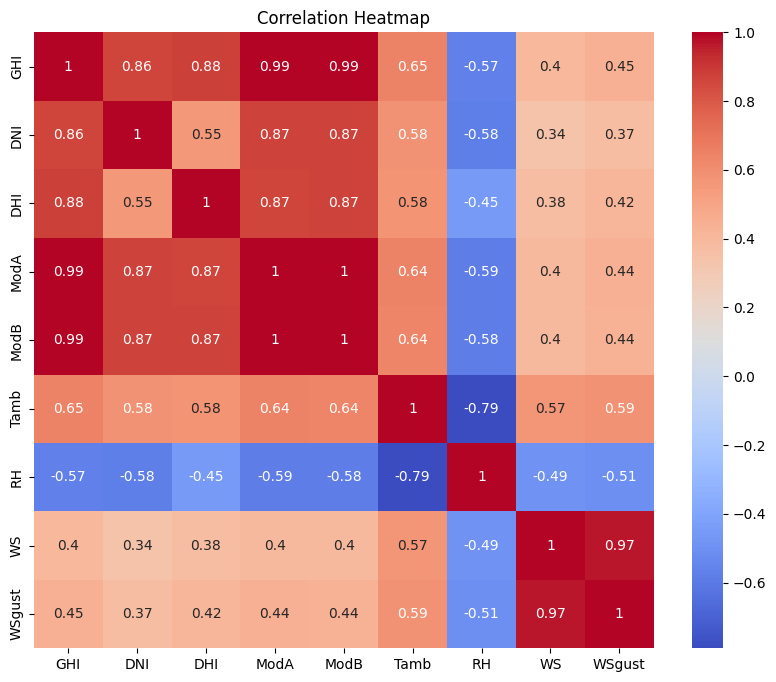

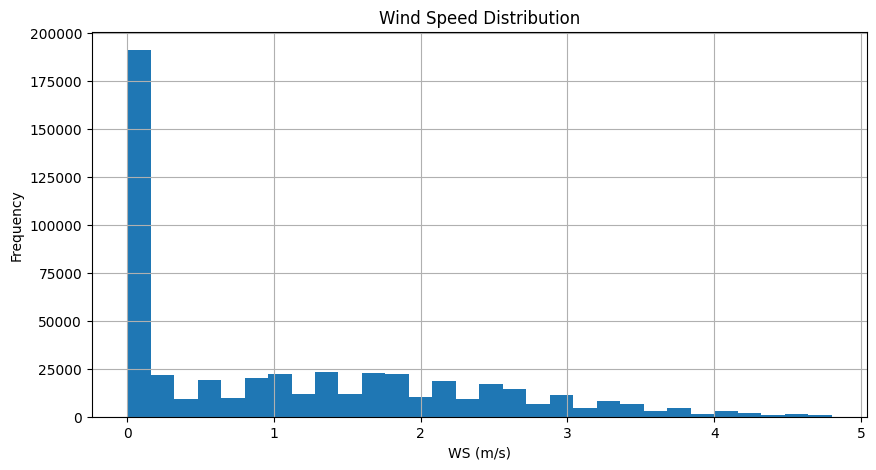

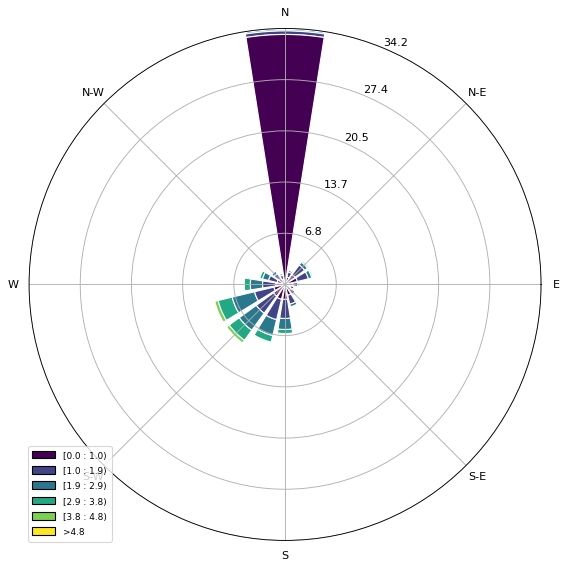

In [ ]:
# =========================
# Optimized Full EDA with Cleaning Impact
# =========================

# Author: Rowda Hassan
# Description: Full Exploratory Data Analysis (EDA) and Cleaning Impact Assessment
# Optimized for performance on large CSV files.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes

# Plot inline (for Jupyter)
%matplotlib inline
pd.set_option('display.max_columns', None)


# ======================================================
# Step 1: Load Data Efficiently (Chunked + Optimized Types)
# ======================================================

def optimize_dtypes(df):
    """Downcast numerical columns to reduce memory usage."""
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df


# Use low_memory=False to prevent dtype guessing issues
print("Loading raw dataset...")
df_raw = pd.read_csv("../data/raw/sierraleone-bumbuna.csv", low_memory=False)
print("Loading cleaned dataset...")
df_clean = pd.read_csv("../data/sierraleone-bumbuna-clean.csv", low_memory=False)

# Optimize memory usage
df_raw = optimize_dtypes(df_raw)
df_clean = optimize_dtypes(df_clean)

# Add cleaning flag
df_raw["cleaning_flag"] = "Raw"
df_clean["cleaning_flag"] = "Cleaned"

# Combine for comparison
df_compare = pd.concat([df_raw, df_clean], ignore_index=True)

# Convert Timestamp
df_compare["Timestamp"] = pd.to_datetime(df_compare["Timestamp"], errors="coerce")
df_compare.dropna(subset=["Timestamp"], inplace=True)
df_compare.set_index("Timestamp", inplace=True)

print("✅ Data successfully loaded and optimized.")


# ======================================================
# Step 2: Summary Statistics & Missing Values
# ======================================================

print("\n=== Summary Statistics ===")
display(df_compare.describe())

print("\n=== Missing Values ===")
display(df_compare.isna().sum())


# ======================================================
# Step 3: Time Series Overview (Sampled for Speed)
# ======================================================

# Sample data for quick plotting (if dataset is huge)
sample_df = df_clean.sample(n=min(10000, len(df_clean)), random_state=42)

plt.figure(figsize=(15,6))
plt.plot(sample_df["Timestamp"], sample_df["GHI"], label="GHI", alpha=0.6)
plt.plot(sample_df["Timestamp"], sample_df["DNI"], label="DNI", alpha=0.6)
plt.plot(sample_df["Timestamp"], sample_df["DHI"], label="DHI", alpha=0.6)
plt.title("Solar Irradiance (Sampled View)")
plt.xlabel("Timestamp")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.tight_layout()
plt.show()

# Daily averages
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"], errors="coerce")
df_clean.dropna(subset=["Timestamp"], inplace=True)

daily_avg = df_clean.set_index("Timestamp")[["GHI","DNI","DHI"]].resample("D").mean()
daily_avg.plot(figsize=(15,5), title="Daily Average Solar Irradiance")
plt.tight_layout()
plt.show()



# ======================================================
# Step 4: Hourly & Monthly Patterns
# ======================================================

df_clean["Hour"] = df_clean["Timestamp"].dt.hour
df_clean["Month"] = df_clean["Timestamp"].dt.month

hourly_avg = df_clean.groupby("Hour")[["GHI","DNI","DHI"]].mean()
monthly_avg = df_clean.groupby("Month")[["GHI","DNI","DHI"]].mean()

# Plot hourly average
hourly_avg.plot(kind="bar", figsize=(12,5), title="Average Solar Irradiance by Hour")
plt.tight_layout()
plt.show()

# Plot monthly average
monthly_avg.plot(kind="bar", figsize=(12,5), title="Average Solar Irradiance by Month")
plt.tight_layout()
plt.show()


# ======================================================
# Step 5: Scatter & Bubble Plots (Sampled for Speed)
# ======================================================

sns.scatterplot(x="Tamb", y="GHI", data=sample_df, alpha=0.4)
plt.title("GHI vs Temperature (Sampled)")
plt.tight_layout()
plt.show()

sns.scatterplot(x="RH", y="GHI", data=sample_df, alpha=0.4)
plt.title("GHI vs Relative Humidity (Sampled)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.scatter(sample_df["Tamb"], sample_df["GHI"], s=sample_df["RH"], alpha=0.3)
plt.xlabel("Temperature (°C)")
plt.ylabel("GHI (W/m²)")
plt.title("GHI vs Temperature (Bubble size = RH)")
plt.tight_layout()
plt.show()


# ======================================================
# Step 6: Correlation Heatmap
# ======================================================

corr_features = ["GHI","DNI","DHI","ModA","ModB","Tamb","RH","WS","WSgust"]
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[corr_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# ======================================================
# Step 7: Wind Analysis
# ======================================================

df_clean["WS"].hist(bins=30, figsize=(10,5))
plt.title("Wind Speed Distribution")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

ax = WindroseAxes.from_ax()
ax.bar(df_clean["WD"], df_clean["WS"], normed=True, opening=0.8, edgecolor="white")
ax.set_legend()
plt.show()


# ======================================================
# Step 8: Cleaning Impact (Pre vs Post Cleaning)
# ======================================================

avg_mod = df_compare.groupby("cleaning_flag")[["ModA","ModB"]].mean()
print("\n=== Average ModA & ModB Pre vs Post Cleaning ===")
display(avg_mod)

avg_mod.plot(kind="bar", figsize=(8,5))
plt.title("Average ModA & ModB: Pre vs Post Cleaning")
plt.ylabel("Average Sensor Reading")
plt.tight_layout()
plt.show()

print("✅ EDA completed successfully with optimized performance.")
